# BA optimization

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


파이썬 코드를 실행하기 전에 항상 모든 모듈을 reload 하도록 강제 설정

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import selfies as sf
import torch
import time
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
## Inter-op parallelism
torch.set_num_interop_threads(4)
torch.get_num_interop_threads()
## Intra-op parallelism
torch.set_num_threads(4)
torch.get_num_threads()

4

In [5]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [6]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData
from rebadd.reinforce import REINFORCE_SCST_OFFPOLICY as REINFORCE

# 1. Generator

## 1-1) Data loading for generators

In [7]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = os.path.join('processed_data', 'gsk3_jnk3_qed_sa')
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = os.path.join('outputs_2_optimize_ReBADD', 'jnk3')
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [8]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 781797
Number of vocabulary: 53687
Maximum of seqlen: 40


## 1-2) Pretrained generators

In [9]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 40,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 1e-4,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [10]:
my_generator_after  = StackAugmentedVAE(**kwargs_generator)

In [11]:
class CKPTCONFIGS:
    def __init__(self):
        self.model_path = os.path.join('outputs_1_pretraining_ReBADD', 'gsk3_jnk3_qed_sa', 'checkpoint.pth')
        
ckptconfigs = CKPTCONFIGS()

In [12]:
my_generator_after.load_model(ckptconfigs.model_path)

# 2. Reinforcement learning

In [13]:
from ReBADD_config import Reward_jnk3 as Reward

## 2-1) RL design

In [14]:
my_reward_ft = Reward()

In [15]:
ReBADD = REINFORCE(data=gen_data, generator=my_generator_after, reward_ft=my_reward_ft, zeta=0.9999)

## 2-2) Training

In [16]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.csv')
plot_path = os.path.join(dataconfigs.output_dir, "plots_reward_losses.pdf")

In [17]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        z = generator.sample_latent_vectors()
        sel = generator.evaluate(gen_data, z=z)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [18]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [19]:
def show_reward_loss(rewards, losses, figsize=(8,2.5), filepath=None):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    
    ax[0].plot(rewards)
    ax[0].set_xlabel('Training iteration')
    ax[0].set_ylabel('Average reward')
    ax[1].plot(rl_losses, 'r')
    ax[1].set_xlabel('Training iteration')
    ax[1].set_ylabel('Loss')
    
    plt.tight_layout()
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)

In [20]:
def write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                  jnk_list,
                  execution_times, filepath):
    
    df_history = pd.DataFrame({"REWARD":tr_rewards,
                               "LOSS":rl_losses,
                               "LOSS_RECONST":reconst_losses,
                               "LOSS_ENTROPY":entropy_losses,
                               "JNK3":jnk_list,
                               "EXEC_TIME":execution_times})
    
    df_history.to_csv(filepath, index=False)
    return df_history

In [21]:
# Setting up some parameters for the experiment
n_iterations = 500
checkpoint_stepsize = 50
behavior_stepsize = 20

[0001] rl_loss: 0.702	reconst_loss: 0.615	entropy_loss: 0.088	reward: 0.341	tau: 0.300	(24.970 sec)
[0002] rl_loss: 1.332	reconst_loss: 1.247	entropy_loss: 0.084	reward: 0.554	tau: 0.303	(49.360 sec)
[0003] rl_loss: 2.734	reconst_loss: 2.642	entropy_loss: 0.092	reward: 1.098	tau: 0.311	(97.643 sec)
[0004] rl_loss: 2.473	reconst_loss: 2.372	entropy_loss: 0.101	reward: 1.014	tau: 0.318	(121.945 sec)
[0005] rl_loss: 2.087	reconst_loss: 1.982	entropy_loss: 0.105	reward: 0.693	tau: 0.322	(146.678 sec)
[0006] rl_loss: 1.739	reconst_loss: 1.636	entropy_loss: 0.103	reward: 0.554	tau: 0.324	(220.386 sec)
[0007] rl_loss: 1.058	reconst_loss: 0.945	entropy_loss: 0.112	reward: 0.404	tau: 0.325	(269.490 sec)
[0008] rl_loss: 0.773	reconst_loss: 0.654	entropy_loss: 0.119	reward: 0.341	tau: 0.325	(342.144 sec)
[0009] rl_loss: 3.137	reconst_loss: 3.019	entropy_loss: 0.118	reward: 1.001	tau: 0.332	(366.639 sec)
[0010] rl_loss: 4.242	reconst_loss: 4.121	entropy_loss: 0.121	reward: 1.464	tau: 0.343	(391.38

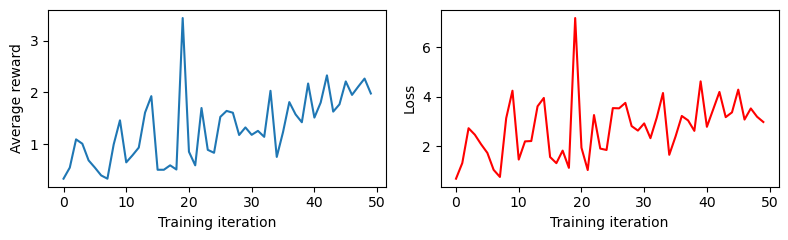

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.89it/s]


Sample trajectories: 100
[0.000]    N1(C(O)C1=C)C(C2)=COC(=O)N2C
[0.030]    C#CNC(=O)C(C1=C(N)COC1=O)C2=CC=CN=C2
[0.010]    COC1=CC=C(C=C1)N2C=CN=C2C=CCO
[0.000]    N#CC=CC#CCOCSCC(=O)NC1=CC=C(C=C1)N2CCOCC2
[0.040]    CC(C)C=C(C)C=C(OC)C(N=CN)CN1CCCC1CN2CCC3=C(C2)NC4=CC=CC=C34
[0.010]    N1CCC(C1O)N2CCC(CC2)NC(C3=CC=C(F)C=C3)CC4=CC=C(Cl)C=C4
[0.000]    NC=NCBr
[0.720]    CCNC(=O)NC1=CC(=CC=N1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.010]    CC1=CC=C(O1)CNC(=O)C2=C([O-1])CCC=CC=CC=C2C3=CSC(=C3)C(=O)N(C)C(C)C
[0.080]    CS(=O)(=O)CCN1CCC(CC1)CCN2C(=O)C=CC(C3=CC=C(Cl)C=C3)=C4C=CC(Br)=CC=NC=C24
[0.090]    CCN(CC1=CC=NC=C1)C(=O)COC2=CC=C3C=CC=CC3=C2C4=CC=CC=C4
[0.020]    CC1=CC(=NC(C)=N1)NC(=O)CS(=O)(=O)C2=CC=CC=C2F
[0.060]    O=[N+1]([O-1])C=CCCC=CN=C(O)CSN1CCOCC1
[0.020]    CNC(=O)C=C1C=CC=C(C=C1Br)C2CC(=CS2)C3=CC=CC=C3
[0.010]    CC(C)(N)C(=O)NCCCCCCCCCCCOC=CC=CCCN(C)C1=CC=C(C=C1)C=CC2=CC=CC=C2
[0.100]    O=C(C1=CC=CC=N1)CCCC2=CC(=CC=C2)C3=CN=C(S3)C4=CC=C(C=C4)CC5=CNC(=N5)C6=CC=CC=C6
[0.58

[0073] rl_loss: 3.110	reconst_loss: 2.636	entropy_loss: 0.474	reward: 2.698	tau: 1.095	(2045.963 sec)
[0074] rl_loss: 3.189	reconst_loss: 2.709	entropy_loss: 0.479	reward: 2.711	tau: 1.111	(2073.839 sec)
[0075] rl_loss: 3.011	reconst_loss: 2.526	entropy_loss: 0.485	reward: 2.688	tau: 1.127	(2102.764 sec)
[0076] rl_loss: 2.905	reconst_loss: 2.415	entropy_loss: 0.491	reward: 2.744	tau: 1.143	(2133.515 sec)
[0077] rl_loss: 2.980	reconst_loss: 2.479	entropy_loss: 0.501	reward: 2.926	tau: 1.161	(2161.324 sec)
[0078] rl_loss: 2.893	reconst_loss: 2.394	entropy_loss: 0.499	reward: 2.686	tau: 1.176	(2190.677 sec)
[0079] rl_loss: 2.934	reconst_loss: 2.422	entropy_loss: 0.512	reward: 2.884	tau: 1.193	(2219.625 sec)
[0080] rl_loss: 3.035	reconst_loss: 2.521	entropy_loss: 0.515	reward: 2.836	tau: 1.210	(2251.983 sec)
[0081] rl_loss: 2.957	reconst_loss: 2.438	entropy_loss: 0.519	reward: 2.846	tau: 1.226	(2282.991 sec)
[0082] rl_loss: 2.947	reconst_loss: 2.422	entropy_loss: 0.525	reward: 2.827	tau: 1

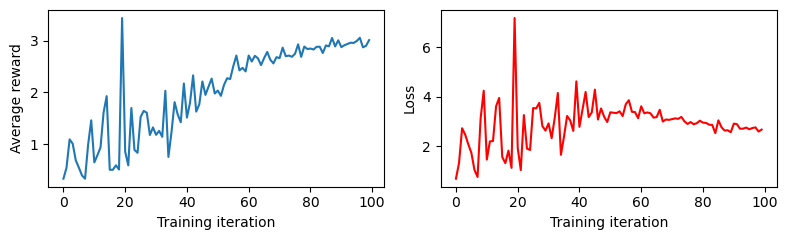

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.10it/s]


Sample trajectories: 100
[0.830]    COC1=CC(=CC(OC)=C1OC)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.010]    NC=CCC1C2NC=NC=CC=CC=CC2=N1
[0.730]    CC(=O)NC1=CC=C(C=C1)C2=CC=CC(=C2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.040]    C1C=CC(CC1)N2N=C(C(=O)N3CCOCC3)C=C2C4=CC=CC=C4OCCNCCCC(=O)N=CC(OC)=COC
[0.030]    CCOC(=O)C1=C(N)C2=CC=C(N=C2S1)C3=CC=C(O3)CCCNC(N)=O
[0.000]    N1=CN=C1
[0.840]    CC1=CC=CC(=C1)C2=NC3=CC(=CC=C3N2)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.140]    C1CNCCC=CC1C2=C(C=NN2)C3=CC=NC(C)=C3
[0.800]    CSC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.010]    CC1=CC=C(C=C1)N=NC2=CC=C(C=C2)C=NNC(=O)C3=CC=C(C=C3)N4CCN(C)CC4
[0.000]    COC1=C2C=C(C=C1)NC(=O)C=CC=C2NC(=O)C3CCCN3C(=O)CC(C)(C)N
[0.020]    CCCN(CCC)C(=O)C1=CC2=CC(=C1)N(C)C(=N2)NC=C(Cl)C=C(Cl)C=COC(F)(F)F
[0.860]    O=S(=O)(C1=CC=C(Cl)C=C1)C2=CN(N=C2)C3=CC=C(C=C3)C4=CC=NC(=N4)NC5=CC=C(C=C5)N6CCOCC6
[0.020]    CCC1=CC=C(C=C1)C=CCCNCCC=CNC2=CC=C(C=C2)C3=CC=CC=C3
[0.710]    CN1N=C(C(F)(F)F)C=C1C2=CC=CC(=C2)C(=O)NC3=CC

[0118] rl_loss: 2.408	reconst_loss: 1.677	entropy_loss: 0.731	reward: 3.096	tau: 1.773	(3494.270 sec)
[0119] rl_loss: 2.384	reconst_loss: 1.646	entropy_loss: 0.738	reward: 3.058	tau: 1.786	(3526.294 sec)
[0120] rl_loss: 2.625	reconst_loss: 1.882	entropy_loss: 0.743	reward: 3.143	tau: 1.800	(3559.789 sec)
[0121] rl_loss: 2.429	reconst_loss: 1.685	entropy_loss: 0.744	reward: 2.982	tau: 1.811	(3592.542 sec)
[0122] rl_loss: 2.445	reconst_loss: 1.694	entropy_loss: 0.751	reward: 3.138	tau: 1.825	(3628.505 sec)
[0123] rl_loss: 2.421	reconst_loss: 1.657	entropy_loss: 0.764	reward: 3.189	tau: 1.838	(3659.960 sec)
[0124] rl_loss: 2.324	reconst_loss: 1.564	entropy_loss: 0.761	reward: 3.080	tau: 1.851	(3694.649 sec)
[0125] rl_loss: 2.609	reconst_loss: 1.840	entropy_loss: 0.769	reward: 3.102	tau: 1.863	(3731.803 sec)
[0126] rl_loss: 2.135	reconst_loss: 1.360	entropy_loss: 0.775	reward: 3.143	tau: 1.876	(3764.187 sec)
[0127] rl_loss: 2.406	reconst_loss: 1.620	entropy_loss: 0.786	reward: 3.184	tau: 1

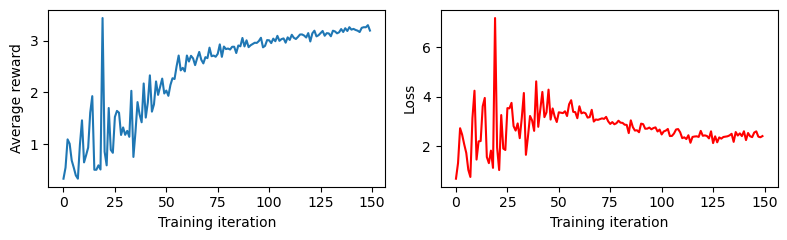

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.84it/s]


Sample trajectories: 100
[0.810]    COC1=CC=C(C=C1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.870]    C1C=C(C(Br)=C1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.850]    OC1=CC=CC(=C1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.730]    NC(=O)NC1CCC(CC1)CC2=CC=C(C=C2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.880]    CC1=CC(=NO1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.860]    N#CC1=CC=C(C=C1)C2=CC=NC(=C2)NC3=CC=C(C=C3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.660]    C1=CC=NC(=C12)NC3CCN(C3C2)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.670]    NN=CC1=CC=CC=C1N2CCN(CC2)C(=O)NC3=CC=C(C=C3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.730]    CCCCC1=CC=C(C=C1)C2=NC(=NO2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.550]    CC=CSC=NNCC1=CC=NC(=C1)NC2=CC=C(C=C2)N3CCOCC3
[0.860]    C1=CC=C(C=C1)C2=NC(=NO2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.850]    OC1=CC=CC(=C1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.850]    CC1=CC=CC=C1C2=CC=C(C=C2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.000]    FC=O
[0.640]    NC1=NC=C(C(=O)N1)C=NC(C=C(C)NC=C)C2=

[0164] rl_loss: 2.422	reconst_loss: 1.437	entropy_loss: 0.985	reward: 3.250	tau: 2.302	(5089.194 sec)
[0165] rl_loss: 2.367	reconst_loss: 1.380	entropy_loss: 0.988	reward: 3.266	tau: 2.312	(5125.275 sec)
[0166] rl_loss: 2.566	reconst_loss: 1.567	entropy_loss: 0.998	reward: 3.254	tau: 2.321	(5158.266 sec)
[0167] rl_loss: 2.429	reconst_loss: 1.422	entropy_loss: 1.006	reward: 3.288	tau: 2.331	(5195.294 sec)
[0168] rl_loss: 2.292	reconst_loss: 1.283	entropy_loss: 1.009	reward: 3.280	tau: 2.341	(5228.895 sec)
[0169] rl_loss: 2.351	reconst_loss: 1.333	entropy_loss: 1.017	reward: 3.287	tau: 2.350	(5265.015 sec)
[0170] rl_loss: 2.493	reconst_loss: 1.474	entropy_loss: 1.019	reward: 3.308	tau: 2.360	(5300.561 sec)
[0171] rl_loss: 2.402	reconst_loss: 1.378	entropy_loss: 1.024	reward: 3.326	tau: 2.369	(5338.884 sec)
[0172] rl_loss: 2.233	reconst_loss: 1.198	entropy_loss: 1.034	reward: 3.320	tau: 2.379	(5370.485 sec)
[0173] rl_loss: 2.291	reconst_loss: 1.258	entropy_loss: 1.033	reward: 3.309	tau: 2

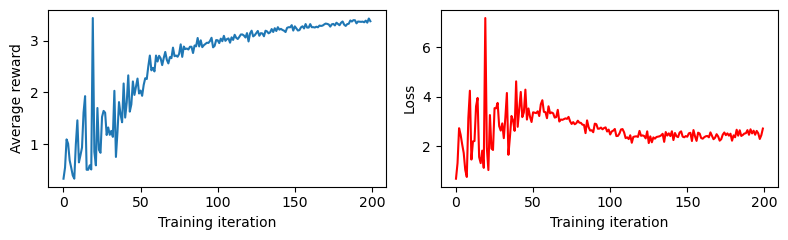

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.39it/s]


Sample trajectories: 100
[0.710]    N1C=C(CC(O)=O)C2=CC=CC=C2C1NC3=CC=C(C=C3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.850]    C1CCN(OC1=O)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.860]    COC1=CC(C=O)=CC(=C1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.030]    NC=NC(C1=CC=CC=C1)=CC(=O)C=CCCCCCOC=CCCC2=CC=C(F)C=C2
[0.850]    NC1=CC(=CC=N1)C2=CC=NC(=C2)NC3=CC=C(C=N3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.700]    COC1CC(=O)NC=CCCN1C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.020]    COC1=CC=CC=C1N2CCC3=CC=CC=C3C2C4=NC=CN4C
[0.750]    CCOC1=CC=C(C(Cl)=C1)C2=CC=NC(=C2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.820]    NC(=O)NC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.640]    O=C(NC1=CC=CC=C1)CC(NC2CC2)C3=CC=C(C=C3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.680]    COC(=O)C=CC(=O)NC1=CC=C(C=C1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCNCC4
[0.770]    CCOC1=CC=CC=C1NC2=NC=CC(=N2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.620]    CN(C)C1=CC=CC(=C1)C=C2C(N=C3SC=CN23)C4=CC=NC(=C4)NC5=C

[0215] rl_loss: 2.811	reconst_loss: 1.555	entropy_loss: 1.256	reward: 3.422	tau: 2.725	(6903.255 sec)
[0216] rl_loss: 2.426	reconst_loss: 1.155	entropy_loss: 1.271	reward: 3.395	tau: 2.732	(6933.149 sec)
[0217] rl_loss: 2.638	reconst_loss: 1.372	entropy_loss: 1.266	reward: 3.423	tau: 2.739	(6963.333 sec)
[0218] rl_loss: 2.771	reconst_loss: 1.492	entropy_loss: 1.279	reward: 3.396	tau: 2.745	(7002.001 sec)
[0219] rl_loss: 2.741	reconst_loss: 1.459	entropy_loss: 1.282	reward: 3.429	tau: 2.752	(7035.154 sec)
[0220] rl_loss: 2.632	reconst_loss: 1.348	entropy_loss: 1.284	reward: 3.424	tau: 2.759	(7066.928 sec)
[0221] rl_loss: 2.374	reconst_loss: 1.077	entropy_loss: 1.297	reward: 3.430	tau: 2.766	(7096.961 sec)
[0222] rl_loss: 2.718	reconst_loss: 1.423	entropy_loss: 1.295	reward: 3.434	tau: 2.772	(7137.320 sec)
[0223] rl_loss: 2.748	reconst_loss: 1.448	entropy_loss: 1.300	reward: 3.439	tau: 2.779	(7166.699 sec)
[0224] rl_loss: 2.769	reconst_loss: 1.462	entropy_loss: 1.307	reward: 3.427	tau: 2

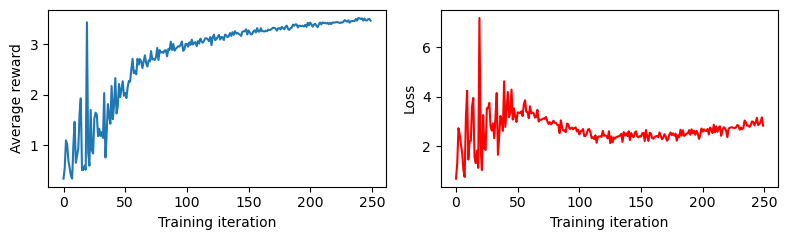

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.48it/s]


Sample trajectories: 100
[0.840]    C1CN(CS1(=O)=O)C2=CC=NC(=C2)NC3=CC=C(C=C3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.000]    NC1=NC=NC=C1N=C(C2=CC=C(Cl)C=C2)NC3CCCC3
[0.720]    C=CC(=O)NC1=CC=CC(=C1)CNC2=NC(=NC=C2Cl)COC3=CC=NC(=C3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.830]    C1CCNNC1C(=O)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=NC(=C4)NC5=CC(=CC=C5Cl)C6=CC=NC(=C6)NC7=CC=C(C=C7)N8CCOCC8
[0.000]    C#CC(O)=O
[0.850]    COC1=CC=C2NC(=CC2=C1)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.850]    C1=CC=CC(=C1)C2=CC=NC(=C2)C3=CC=C(C=C3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.870]    C1=CN=CC(=C1)C2=CC=NC(=C2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.880]    FC1=CC=CC(=C1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.650]    N1C=CC(N2CCN(C)CC2)=CC=C1C3=CC=NC(=C3)NC4=CC=C(C=C4)S(=O)(=O)C5CCN(CC5)C(=O)C6=CC=CC=C6
[0.050]    COC=C1C(C(C)C)=NC(=N1)NC=NC2=NC3=NC(Cl)=C(Cl)C=C3N2
[0.870]    CNC1=CC(=NC=N1)C2=CC=NC(=C2)OC3=CC=CC(=C3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.670]    O=[N+1]([O-1])C1=CN(C=N1)C2=CC=C(C=C2)CCN3CCN(

[0259] rl_loss: 3.155	reconst_loss: 1.664	entropy_loss: 1.491	reward: 3.521	tau: 2.994	(8393.251 sec)
[0260] rl_loss: 2.796	reconst_loss: 1.301	entropy_loss: 1.495	reward: 3.519	tau: 3.000	(8430.482 sec)
[0261] rl_loss: 3.131	reconst_loss: 1.635	entropy_loss: 1.496	reward: 3.571	tau: 3.005	(8460.873 sec)
[0262] rl_loss: 3.071	reconst_loss: 1.569	entropy_loss: 1.502	reward: 3.535	tau: 3.011	(8495.478 sec)
[0263] rl_loss: 2.991	reconst_loss: 1.488	entropy_loss: 1.503	reward: 3.483	tau: 3.015	(8532.610 sec)
[0264] rl_loss: 2.903	reconst_loss: 1.392	entropy_loss: 1.510	reward: 3.536	tau: 3.021	(8565.376 sec)
[0265] rl_loss: 3.070	reconst_loss: 1.554	entropy_loss: 1.516	reward: 3.494	tau: 3.025	(8596.122 sec)
[0266] rl_loss: 3.164	reconst_loss: 1.650	entropy_loss: 1.514	reward: 3.558	tau: 3.031	(8636.282 sec)
[0267] rl_loss: 3.032	reconst_loss: 1.511	entropy_loss: 1.521	reward: 3.532	tau: 3.036	(8669.288 sec)
[0268] rl_loss: 3.083	reconst_loss: 1.552	entropy_loss: 1.531	reward: 3.524	tau: 3

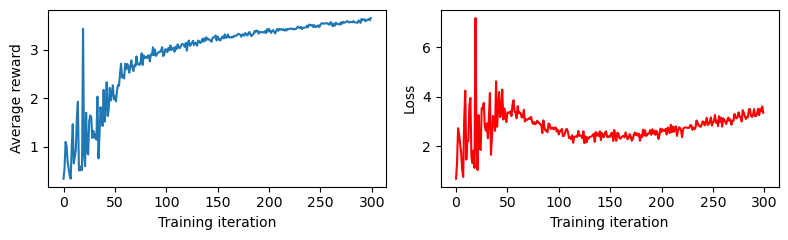

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.73it/s]


Sample trajectories: 100
[0.010]    CC=C1C=CC=C2N1C(=CS2)C3=CC=C(Br)C=C3
[0.010]    COC=CCCOCCCC1CN(S(C)(=O)=O)N2C(=S3)N1C=CC=C3S2
[0.000]    C12OC1=C2CF
[0.840]    NC1=CC=C(C=N1)C2=CC=NC(=C2)NC3=CC=C(O3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.810]    C=NNC1=NC(=CS1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.700]    O=CNNC=CN=CCCCC1=CC=C(C=C1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.850]    OC1=CC=C(C=C1O)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.730]    NC1=NC(N)=CC(=N1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4CCN5CCC6=CC=CC=C65
[0.110]    N1C(N)CCNC12CCC3=NN(NC4=C3CC2)C5=C(NS(C)(=O)=O)C=CC=C54
[0.860]    C1=CC=C(C=C1)C2=CC=NC(=C2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.780]    NC=COC1=NC=NC=C1C2=NC3=CC(=CC=C3N2)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.330]    CON=CC=CSC1=CC=NC(=C1)NC2=CC=C(C=C2)OCC3CC3
[0.870]    CC=NN(NCC1=CC=C(F)C=C12)C=NC(=CC2=N)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.150]    NC1=CC=CC(=C1)C2=CC=NC(=C2)NCCCN(CO)CC3=CC=C(OC)C=C3
[0.850]    CN(C)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=NC(=C3)

[0305] rl_loss: 3.589	reconst_loss: 1.879	entropy_loss: 1.710	reward: 3.619	tau: 3.212	(9992.588 sec)
[0306] rl_loss: 3.288	reconst_loss: 1.579	entropy_loss: 1.708	reward: 3.629	tau: 3.216	(10023.631 sec)
[0307] rl_loss: 3.660	reconst_loss: 1.954	entropy_loss: 1.705	reward: 3.635	tau: 3.220	(10053.753 sec)
[0308] rl_loss: 3.471	reconst_loss: 1.749	entropy_loss: 1.722	reward: 3.605	tau: 3.224	(10094.862 sec)
[0309] rl_loss: 3.561	reconst_loss: 1.856	entropy_loss: 1.705	reward: 3.627	tau: 3.228	(10130.428 sec)
[0310] rl_loss: 3.258	reconst_loss: 1.540	entropy_loss: 1.718	reward: 3.591	tau: 3.232	(10161.396 sec)
[0311] rl_loss: 3.611	reconst_loss: 1.890	entropy_loss: 1.721	reward: 3.646	tau: 3.236	(10193.743 sec)
[0312] rl_loss: 3.603	reconst_loss: 1.872	entropy_loss: 1.731	reward: 3.652	tau: 3.240	(10232.196 sec)
[0313] rl_loss: 3.581	reconst_loss: 1.845	entropy_loss: 1.736	reward: 3.681	tau: 3.245	(10268.860 sec)
[0314] rl_loss: 3.626	reconst_loss: 1.890	entropy_loss: 1.736	reward: 3.66

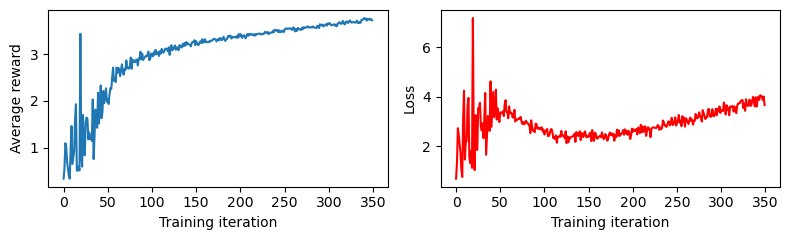

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.01it/s]


Sample trajectories: 100
[0.670]    O1C=CC=C2C=CC=CC2=C1C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5CCNCC6CCCO6
[0.910]    NC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.660]    FC(F)CNC=NCOCC1=CC=C(C=C1)C2=CC=NC(=C2)NC3=CC=CC(=C3)C4=CC=NC(=C4)NC5=CC=CC(=C5)OC6=CC=NC(=N6)C7=CC=NC(=C7)NCC8=CC=C(C=C8)C9=CC=NC(=C9)NC%10=CC=C(C=C%10)CCN%11CCOCC%11
[0.800]    OCC1=CC2=CC(=CC=C2N1)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.000]    C1NC=N1
[0.820]    N1C=NC2=CC(=CC=C21)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCCCCC5
[0.750]    NCC1=CC=CC(=C1)C2=CC=NC(=N2)C3=CC=CC(=N3)C4=CC=CC(=C4)C5=CC=NC(=C5)C6=CC=NC(=C6)NC7=CC=C(C=C7)N8CCOCC8OCC=C(F)C=CF
[0.760]    CS(=O)(=O)CC1=CC=C(S1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.220]    FC1=CC=CC(=C1)C2=CC=NC(=C2)NCC3OCCCN3CC4=C(F)C=CC=C4F
[0.880]    NC1=NC2=CC=C(C=C2N1)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.650]    NC1=CC(=CC=N1)C2=CC=NC(=C2)NC3=C4C=C(C=C3)N5CCOCC5C(=O)N4
[0.820]    NONNC1=CC=CC=C1C2=CC=NC(=C2)NC3=CC=CC(=C3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.9

[0352] rl_loss: 4.153	reconst_loss: 2.257	entropy_loss: 1.896	reward: 3.742	tau: 3.394	(11613.483 sec)
[0353] rl_loss: 3.949	reconst_loss: 2.060	entropy_loss: 1.889	reward: 3.701	tau: 3.397	(11658.772 sec)
[0354] rl_loss: 4.216	reconst_loss: 2.303	entropy_loss: 1.913	reward: 3.782	tau: 3.401	(11689.314 sec)
[0355] rl_loss: 3.935	reconst_loss: 2.025	entropy_loss: 1.910	reward: 3.735	tau: 3.404	(11721.180 sec)
[0356] rl_loss: 4.075	reconst_loss: 2.155	entropy_loss: 1.920	reward: 3.723	tau: 3.407	(11756.678 sec)
[0357] rl_loss: 3.862	reconst_loss: 1.930	entropy_loss: 1.932	reward: 3.731	tau: 3.410	(11794.781 sec)
[0358] rl_loss: 4.175	reconst_loss: 2.277	entropy_loss: 1.898	reward: 3.779	tau: 3.414	(11827.527 sec)
[0359] rl_loss: 3.777	reconst_loss: 1.835	entropy_loss: 1.942	reward: 3.742	tau: 3.417	(11858.375 sec)
[0360] rl_loss: 4.071	reconst_loss: 2.145	entropy_loss: 1.927	reward: 3.736	tau: 3.420	(11892.696 sec)
[0361] rl_loss: 4.150	reconst_loss: 2.226	entropy_loss: 1.924	reward: 3.7

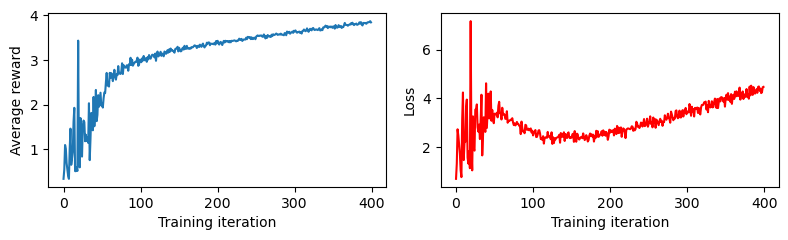

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.69it/s]


Sample trajectories: 100
[0.610]    NC1=NNC=C1C2=CC=NC(=C2)C3=CC=NC(=C3)NC4=CC5=C(C=C4)C6(O)CN(C=C56)C7=CC=NC(=C7)N8CCOCC8
[0.840]    C12C=NC=CC(C(=O)O1)=CC=C2C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.880]    NC1=CC(=CC=C1Cl)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.490]    NC1=NC(=NN1)C2=CC=NC(=C2)NC3=CC=C(C=C3)CC(=O)NC4C5CCCC45
[0.870]    N1C=NC2=CC(=CC=C21)C3=CC=NC(=C3)NC4=CC=CC(=C4)NC5=NC=CC(=N5)C6=CC=NC(=C6)NC7=CC=C(C=C7)N8CCOCC8
[0.880]    CC1=CC=CC(=C1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.880]    CNC1=CC(=CC=N1)C2=CC=NC(=C2)NC3=CC=C(C=C3Br)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.840]    C1NC=C=NN1C2=CC=NC(=C2)C3=CNC(=N3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.870]    CC1=CC(=CC=N1)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.770]    O=[N+1]([O-1])C1=CC=CC(=C1)NC2=NC=CC(=N2)C3=CC4=CC(=CC=C4N3)C5=CC6=NC(=C5)NC=CC=CNC=C6C7=CC=NC(=C7)NC8=CC=C(C=C8)N9CCOCC9
[0.860]    C1=CN=CC(=C1)C2=CC=NC(=C2)NC3=CC=C(S3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.620]    NCN1CCCCC1C2=CC=NC(=C2)NC3=CC=C(C=C3)C4=CC=N

[0402] rl_loss: 4.178	reconst_loss: 2.064	entropy_loss: 2.114	reward: 3.860	tau: 3.554	(13351.096 sec)
[0403] rl_loss: 4.827	reconst_loss: 2.736	entropy_loss: 2.091	reward: 3.847	tau: 3.557	(13387.039 sec)
[0404] rl_loss: 4.459	reconst_loss: 2.351	entropy_loss: 2.108	reward: 3.856	tau: 3.560	(13419.718 sec)
[0405] rl_loss: 4.515	reconst_loss: 2.404	entropy_loss: 2.111	reward: 3.853	tau: 3.563	(13451.300 sec)
[0406] rl_loss: 4.592	reconst_loss: 2.472	entropy_loss: 2.120	reward: 3.884	tau: 3.567	(13487.538 sec)
[0407] rl_loss: 4.072	reconst_loss: 1.906	entropy_loss: 2.166	reward: 3.854	tau: 3.569	(13521.860 sec)
[0408] rl_loss: 4.448	reconst_loss: 2.318	entropy_loss: 2.130	reward: 3.876	tau: 3.572	(13552.545 sec)
[0409] rl_loss: 4.497	reconst_loss: 2.371	entropy_loss: 2.126	reward: 3.838	tau: 3.575	(13588.553 sec)
[0410] rl_loss: 4.432	reconst_loss: 2.277	entropy_loss: 2.155	reward: 3.847	tau: 3.578	(13630.031 sec)
[0411] rl_loss: 4.359	reconst_loss: 2.214	entropy_loss: 2.144	reward: 3.8

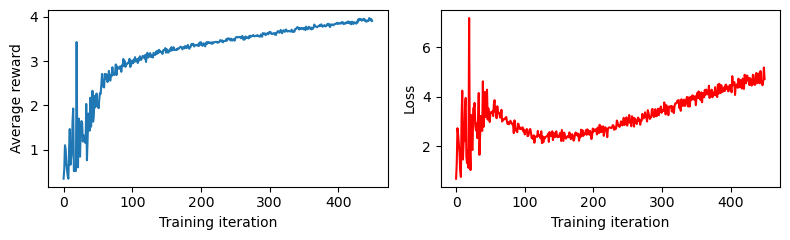

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Sample trajectories: 100
[0.900]    NC1=CC(=CC=C1F)C2=CC(=CC=N2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.910]    CNC1=CC(=CC=N1)C2=CC=NC(=C2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.020]    CC1=CC=CC(=C1C)ONCCN2CCCC2C3=CN=CC=C3N4CCCC4
[0.020]    C1=CC(=NN1)C2=C3C=NC(=C2)OC3=C
[0.070]    FC1=CC=CC(=C1)C2=CC=NC(=C2)C3=CC=CN=C3
[0.680]    CC1=NC=CC(N2)=C1N(CC2)C3=CC=NC(=C3C)C4=CC=NC(=C4)NC=CC=CCCCC=NNCNC5=CN(C(=O)N(C)C)CC=C5C6=CC=C(C=C6Cl)C7=CC=NC(=C7)NC8=CC=C(C=C8)N9CCOCC9
[0.760]    C12=CN=C(C1C=C2OC)NCC3=NC(=NO3)C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.140]    N1C=NC2=CC(=CC=C12)C3=CC4=NC(=C3)NC5=CC=C(C=C56)C=CN=CC=C4COC=CNC6N=CSN
[0.280]    CS(=O)(=O)C1=CC=CC(=C1)NC2=NC=CC(=N2)C=CC=NCC3CCOCC3CCCBr
[0.610]    OC1=CC=CC(=C1)C2=CC=NC(=C2C)C3=CC=NC(=N3)NC4=CC=C(C=C4)NCCCCN5CCOCC5(C6C=CC(N)=O)NC=CC=C(S6)C7=CC=NC(=C7)NC8=CC9=C(C=C8)N%10CCN(C%10=S)C(=N9)C%11=CC=NC(=C%11)NC%12=C%13C=C(C=C%12)C%13CC#CCSC=NCC=NC=NCC=CC%14=CC=CO%14
[0.730]    N1=CC(OC)=C1OCC2=CC(=CC=C2F)C3=CC=NC(=C3)C4=CC=NC(=C4)NC5=C

[0452] rl_loss: 4.743	reconst_loss: 2.438	entropy_loss: 2.304	reward: 3.923	tau: 3.691	(14943.713 sec)
[0453] rl_loss: 4.897	reconst_loss: 2.591	entropy_loss: 2.306	reward: 3.915	tau: 3.693	(14967.696 sec)
[0454] rl_loss: 4.916	reconst_loss: 2.600	entropy_loss: 2.316	reward: 3.924	tau: 3.695	(14994.770 sec)
[0455] rl_loss: 4.751	reconst_loss: 2.419	entropy_loss: 2.332	reward: 3.928	tau: 3.698	(15017.625 sec)
[0456] rl_loss: 4.968	reconst_loss: 2.643	entropy_loss: 2.325	reward: 3.939	tau: 3.700	(15046.275 sec)
[0457] rl_loss: 4.802	reconst_loss: 2.442	entropy_loss: 2.361	reward: 3.905	tau: 3.702	(15073.411 sec)
[0458] rl_loss: 4.821	reconst_loss: 2.519	entropy_loss: 2.301	reward: 3.899	tau: 3.704	(15097.297 sec)
[0459] rl_loss: 5.081	reconst_loss: 2.740	entropy_loss: 2.341	reward: 3.889	tau: 3.706	(15121.662 sec)
[0460] rl_loss: 5.044	reconst_loss: 2.713	entropy_loss: 2.330	reward: 3.919	tau: 3.708	(15159.306 sec)
[0461] rl_loss: 4.969	reconst_loss: 2.631	entropy_loss: 2.339	reward: 3.9

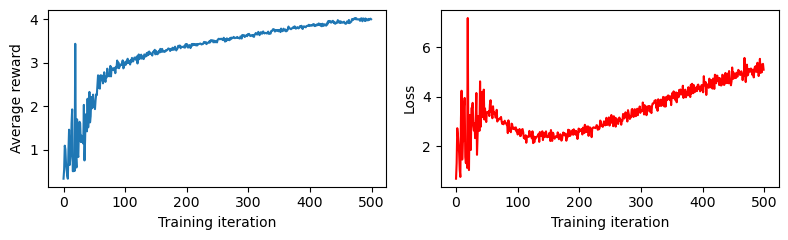

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.91it/s]


Sample trajectories: 100
[0.880]    N#CC1=CC(=CC=C1F)C2=CC=NC(=C2)NC3=CC=C(C=C3)N4CCOCC4
[0.050]    CC1C2CCCN1NC3=CC=C(C=C32)C=CC(=CC4=CC=NC=C4)NC5=CC=CN=C5COCC6CCCN6[O-1]
[0.870]    C12C=CC(=NC1=C2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.190]    CNC1=CC(N2CCOCC2)=NC(=N1)NC3=CC=C(C=C3)N4CCOCC4
[0.800]    N12C=CC=C=CC1C(=N2)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.630]    OC=NC1=CC=C(C=C1C(F)(F)F)C=CC=NC(N2CCOCC2C)OCCN3CCCC3C4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.890]    C1C2=CC(=NN12)C3=CC=NC(=C3)NC4=CC=C(C=C4)N5CCOCC5
[0.500]    FC1=CC(=CC=C1Cl)NC2=NC=CC(=N2)C3=NC4=CC(=CC=C4N3)C5=CC=NC(=C5)N6CCOCC6
[0.110]    CC1=CC2=CC(=CC=C2N1)C3=CC=NC(=C34)CCC=CCCCN4C5=C(C)C=CS5
[0.160]    NC1=NC=C(N1)C=C2C=CCOCC2C3=CC=NC(=C3)NC=CC=CCCC=CC=COCN4CCOCC4
[0.680]    C1NC=CC=C1C=CC2=NC(Cl)=CC(C2C3=CC=NC=C3)=CC4=CC=NC(=C4)NC5=CC=C(C=C5)N6CCOCC6
[0.160]    C(=O)=NCC=NC1=CC=C(C2=CNN=C2)C=C1[N+1](=O)[O-1]
[0.110]    N1C=NC=CC(=N1)C2=CC=CC(C3=CC=NC=C3)=C2N=CC4=CC=C(C=C4)N5CCOCC5
[0.160]    CC1=CC(=NN1)C2=CC=NC(=

In [22]:
tr_rewards = [] # rewards when training the model
rl_losses = [] # loss when training the model
reconst_losses = [] # reconstruction loss
entropy_losses = [] # entropy regularization

jnk_list = []

execution_times = []

## Training RL optimizer
start_time = time.time()

alpha_min = 0.01
alpha_max = 0.3
alpha_inc = (alpha_max - alpha_min) / n_iterations
alpha = alpha_min
for i in range(1, n_iterations+1):
    ## policy gradient
    alpha += alpha_inc
    cur_reward, cur_loss, cur_reconst, cur_entropy = ReBADD.policy_gradient(grad_clipping=1., alpha=alpha)
    
    ## append - reward
    #reward = simple_moving_average(tr_rewards, cur_reward)
    reward = cur_reward
    tr_rewards.append(reward)
    
    ## append - loss
    #rl_loss = simple_moving_average(rl_losses, cur_loss)
    rl_loss = cur_loss
    rl_losses.append(rl_loss)
    #reconst_loss = simple_moving_average(reconst_losses, cur_reconst)
    reconst_loss = cur_reconst
    reconst_losses.append(reconst_loss)
    #entropy_loss = simple_moving_average(entropy_losses, cur_entropy)
    entropy_loss = cur_entropy
    entropy_losses.append(entropy_loss)
        
    ## execution time check
    end_time = time.time()
    exec_time = end_time - start_time
    execution_times.append(exec_time)
    
    ## print - logs
    print(f"[{i:04d}] rl_loss: {rl_loss:.3f}\treconst_loss: {reconst_loss:.3f}\tentropy_loss: {entropy_loss:.3f}\treward: {reward:.3f}\ttau: {ReBADD.tau:.3f}\t({exec_time:.3f} sec)")
        
    ## checkpoint
    avg_jnk = 0.
    avg_qed = 0.
    avg_sa = 0.
    
    if i % checkpoint_stepsize == 0:
        ## save
        ReBADD.generator.save_model(model_path.replace('.pth', f'.pth.{i:04d}'))
        
        ## plotting
        show_reward_loss(tr_rewards, rl_losses)

        ## sampling check
        smiles_cur = SMILES_generate(ReBADD, n_to_generate=100, gen_data=gen_data)
        print(f'Sample trajectories: {len(smiles_cur)}')
        if len(smiles_cur) > 0:
            for sm in smiles_cur:
                _, s_jnk = my_reward_ft(sm, debug=True)
                print(f"[{s_jnk:.3f}]    {sm}")
                avg_jnk += s_jnk
            avg_jnk /= len(smiles_cur)
    
    ## append - binding affinity values
    jnk_list.append(avg_jnk)
    
    ## history save
    _ = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                      jnk_list,
                      execution_times, losses_path)
    
    if i % behavior_stepsize == 0:
        ReBADD.update_behavior()

# 3. Save

In [23]:
ReBADD.generator.save_model(model_path)

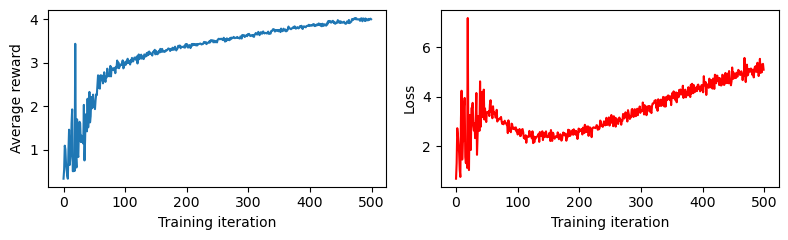

In [24]:
show_reward_loss(tr_rewards, rl_losses, filepath=plot_path)

In [25]:
df_history = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                           jnk_list,
                           execution_times, losses_path)
print(df_history.shape)
print(df_history.head())

(500, 6)
     REWARD      LOSS  LOSS_RECONST  LOSS_ENTROPY  JNK3   EXEC_TIME
0  0.341154  0.702385      0.614640      0.087745   0.0   24.970433
1  0.554355  1.331643      1.247323      0.084321   0.0   49.360495
2  1.097736  2.733501      2.641951      0.091550   0.0   97.642650
3  1.013932  2.472966      2.371615      0.101350   0.0  121.944541
4  0.693147  2.086663      1.981614      0.105049   0.0  146.677717


In [26]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [27]:
n_sampling = 30000

smi_after = SMILES_generate(ReBADD, n_sampling, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [11:13<00:00, 44.51it/s]


In [28]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_2_optimize_ReBADD/jnk3/smi_after.csv
